# BCCNet demo on MNIST

This script demonstrates BCCNet in action on classification of MNIST

* first generates synthetic crowdsourced labels for MNIST. Only 50% of training data is labelled by 4 crowd members with the average reliability of 0.6
* iterates one call of the VB_iteration function and one epoch of backpropagated updates for the parameters of a neural network
* saves weights of the trained neural network
* plots accuracy performance 

Required import

In [6]:
!pip3 install pathlib matplotlib tensorflow

In [12]:
!which pip

/Users/gs0029/opt/anaconda3/bin/pip


In [14]:
import matplotlib
%matplotlib inline

In [16]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

from NNArchitecture.lenet5_mnist import cnn_for_mnist
from SyntheticCrowdsourcing.synthetic_crowd_volunteers import generate_volunteer_labels
from VariationalInference.VB_iteration import VB_iteration
from utils.utils_dataset_processing import shrink_arrays
from VariationalInference import confusion_matrix

Set random seed

In [18]:
rseed = 1000
np.random.seed(rseed)
tf.random.set_seed(rseed)

Parameters

In [19]:
n_classes = 10
crowdsourced_labelled_train_data_ratio = 0.5 # ratio of train data labelled by crowd members
n_crowd_members = 4
crowd_member_reliability_level = 0.6
confusion_matrix_diagonal_prior = 1e-1
n_epoch = 100
batch_size = 32
convergence_threshold = 1e-6 # convergence is measured as change in ELBO

## Load data

In [20]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path=os.getcwd() + '/mnist.npz')

11501568/11490434 [==============================] - 1s 0us/step


Expand dimensions for images to explicitly have 1 channel

In [21]:
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

Select subsample of train data to be "labelled" by crowd members

In [22]:
labelled_train, whole_train = shrink_arrays([x_train, y_train], 
                                            crowdsourced_labelled_train_data_ratio, is_shuffle=True)
x_labelled_train = labelled_train[0]
y_labelled_train = labelled_train[1]
x_train = whole_train[0]
y_train = whole_train[1]

## Generate synthetic crowdsourced labels

In [23]:
crowdsourced_labels = generate_volunteer_labels(n_volunteers=n_crowd_members, n_classes=n_classes, 
                                                gt_labels=y_labelled_train,
                                                n_total_tasks=x_train.shape[0],
                                                reliability_level=crowd_member_reliability_level)

## Set up a neural network and variational parameters

In [24]:
cnn_model = cnn_for_mnist()

2021-09-03 12:43:00.856912: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/gs0029/opt/anaconda3/envs/bccyolo/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [25]:
prior_param_confusion_matrices = confusion_matrix.initialise_prior(n_classes=n_classes, n_volunteers=n_crowd_members,
                                                                   alpha_diag_prior=confusion_matrix_diagonal_prior)
variational_param_confusion_matrices = np.copy(prior_param_confusion_matrices)

## Initialisation of the approximating posterior of true labels

Initial variational inference iteration

In [26]:
initial_nn_output_for_vb_update = np.random.randn(x_train.shape[0], n_classes)

q_t, variational_param_confusion_matrices, lower_bound = \
    VB_iteration(crowdsourced_labels, initial_nn_output_for_vb_update, variational_param_confusion_matrices,
                 prior_param_confusion_matrices)

old_lower_bound = lower_bound

## Main training cycle

Set up evaluation arrays

In [27]:
# based on predictions from the neural network
nn_training_accuracy = np.zeros((n_epoch,), dtype=np.float64)   
# based on approximated posterior for true labels
posterior_estimate_training_accuracy = np.zeros((n_epoch,), dtype=np.float64)  
# based on predictions from the neural network on test data
nn_test_accuracy = np.zeros((n_epoch,), dtype=np.float64)

Training cycle

In [28]:
for epoch in range(n_epoch):
    print(f'epoch {epoch}:')

    # update of parameters of the neural network
    cnn_model.fit(x_train, q_t, epochs=1, shuffle=True, batch_size=batch_size, verbose=0)

    # update of approximating posterior for the true labels and confusion matrices
    # get current predictions from a neural network
    nn_output_for_vb_update = cnn_model.predict(x_train)
    # for numerical stability
    nn_output_for_vb_update = nn_output_for_vb_update - \
        np.tile(np.expand_dims(np.max(nn_output_for_vb_update, axis=1), axis=1), 
                (1, nn_output_for_vb_update.shape[1]))

    q_t, variational_param_confusion_matrices, lower_bound = \
        VB_iteration(crowdsourced_labels, nn_output_for_vb_update, variational_param_confusion_matrices,
                     prior_param_confusion_matrices)

    # evaluation
    nn_training_accuracy[epoch] = np.mean(np.argmax(nn_output_for_vb_update, axis=1) == y_train)
    print(f'\t nn training accuracy: {nn_training_accuracy[epoch]}')

    posterior_estimate_training_accuracy[epoch] = np.mean(np.argmax(q_t, axis=1) == y_train)
    print(f'\t posterior estimate training accuracy: {posterior_estimate_training_accuracy[epoch]}')

    nn_test_prediction = cnn_model.predict(x_test)
    nn_test_accuracy[epoch] = np.mean(np.argmax(nn_test_prediction, axis=1) == y_test)
    print(f'\t nn test accuracy: {nn_test_accuracy[epoch]}')

    # check convergence
    if np.abs((lower_bound - old_lower_bound) / old_lower_bound) < convergence_threshold:
        break

    old_lower_bound = lower_bound

epoch 0:


2021-09-03 12:43:32.576583: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


	 nn training accuracy: 0.09896666666666666
	 posterior estimate training accuracy: 0.4315833333333333
	 nn test accuracy: 0.0999
epoch 1:
	 nn training accuracy: 0.10805
	 posterior estimate training accuracy: 0.44038333333333335
	 nn test accuracy: 0.1038
epoch 2:
	 nn training accuracy: 0.2193
	 posterior estimate training accuracy: 0.5039666666666667
	 nn test accuracy: 0.2269
epoch 3:
	 nn training accuracy: 0.4053
	 posterior estimate training accuracy: 0.61445
	 nn test accuracy: 0.4027
epoch 4:
	 nn training accuracy: 0.93505
	 posterior estimate training accuracy: 0.9148333333333334
	 nn test accuracy: 0.9383
epoch 5:
	 nn training accuracy: 0.9697
	 posterior estimate training accuracy: 0.9476166666666667
	 nn test accuracy: 0.9711
epoch 6:
	 nn training accuracy: 0.9793833333333334
	 posterior estimate training accuracy: 0.9635166666666667
	 nn test accuracy: 0.9784
epoch 7:
	 nn training accuracy: 0.9829166666666667
	 posterior estimate training accuracy: 0.9700833333333333

	 nn test accuracy: 0.9619
epoch 63:
	 nn training accuracy: 0.92095
	 posterior estimate training accuracy: 0.9208
	 nn test accuracy: 0.9603
epoch 64:
	 nn training accuracy: 0.9208666666666666
	 posterior estimate training accuracy: 0.9208
	 nn test accuracy: 0.9626
epoch 65:
	 nn training accuracy: 0.9211166666666667
	 posterior estimate training accuracy: 0.9210666666666667
	 nn test accuracy: 0.9636
epoch 66:
	 nn training accuracy: 0.9210666666666667
	 posterior estimate training accuracy: 0.92105
	 nn test accuracy: 0.9622
epoch 67:
	 nn training accuracy: 0.9210666666666667
	 posterior estimate training accuracy: 0.9210333333333334
	 nn test accuracy: 0.9638
epoch 68:
	 nn training accuracy: 0.9211333333333334
	 posterior estimate training accuracy: 0.9211166666666667
	 nn test accuracy: 0.9628
epoch 69:
	 nn training accuracy: 0.9210666666666667
	 posterior estimate training accuracy: 0.9211166666666667
	 nn test accuracy: 0.9631
epoch 70:
	 nn training accuracy: 0.9212333333

## Output

Save weights

In [14]:
cnn_model.save_weights(os.getcwd() + '/trained_weights')


Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


Plot accuracy performance

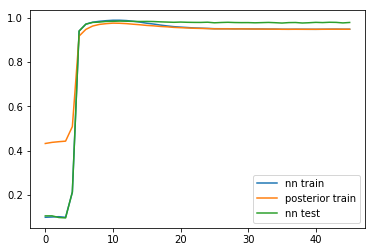

In [15]:
plt.plot(range(epoch), nn_training_accuracy[:epoch], label='nn train')
plt.plot(range(epoch), posterior_estimate_training_accuracy[:epoch], label='posterior train')
plt.plot(range(epoch), nn_test_accuracy[:epoch], label='nn test')
plt.legend()
plt.show()